In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

In [2]:
data = pd.read_csv('data//train.csv')
pred = pd.read_csv('data//test.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = data.values
pred = pred.values

In [4]:
# let us take a small subset just for testing how knn works, we will just take 100 exaples for each class, to avoid 
#sampling bias also
def collect_samples(data, start_index, num_examples):
    train_x = []
    train_y = []
    for i in range(10):
        n = 0
        for index in range(start_index, data.shape[0]):
            if n==num_examples:
                break
            if data[index][0]==i:
                train_x.append(data[index][1:])
                train_y.append(i)
                n+=1
    return np.array(train_x), np.array(train_y)

In [5]:
train_x, train_y = collect_samples(data, 0, 1000)
print(train_x.shape,", ",  train_y.shape)

(10000, 784) ,  (10000,)


train_x, train_y = data[:, 1:], data[:, 0]
train_x.shape, train_y.shape

In [6]:
mu = np.mean(train_x, axis=0)
mu.shape

(784,)

In [7]:
def get_tranformation_matrix_PCA(data, mu, k = 2):
    data_X = data - mu
    #######
    cov_matrix = np.cov(data_X, rowvar=False)
    ##########
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
    #########
    sorted_indices = np.argsort(eigen_values)
    sorted_indices = sorted_indices[::-1]
    sorted_eigen_values = eigen_values[sorted_indices]
    sorted_eigen_vectors = eigen_vectors[:, sorted_indices]
    ########
    transform_matrix = []
    for i in range(k):
        transform_matrix.append(sorted_eigen_vectors[:,i])
    transform_matrix = np.array(transform_matrix)
    transform_matrix = transform_matrix.T
    ######
    return transform_matrix

In [8]:
transform_matrix = get_tranformation_matrix_PCA(train_x, mu, k=2)
data_X = (train_x-mu)@transform_matrix
data_X.shape

(10000, 2)

In [9]:
def visualize(data_X, data_Y, classes):
    colors = cm.rainbow(np.linspace(0, 1, len(classes)))
    data = []
    for class_ in classes:
        data.append(data_X[data_Y==class_])
        #print(class_, ", ", data[class_].shape)
    for i in range(len(colors)):
        plt.scatter(data[i][:,0], data[i][:, 1], c =colors[i])
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


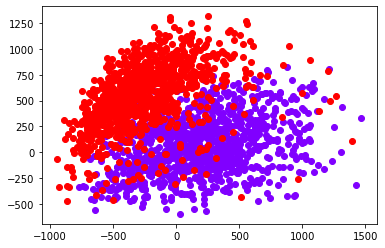

In [11]:
# let us just visualize the first cluster only
visualize(data_X, train_y, [6,9])

In [12]:
#### above we have just visualized how the data looks if it were to be projected in the 2D plane
# but we will convert tha data into 50 dims in the hopw that KNN will improve
## i have assumed that taking 1000 examples of each class will generalize for all examples
# btw my model is missing the randomness, i have taken almost the same examples again and again
transform_matrix = get_tranformation_matrix_PCA(train_x, mu, k=50) ## this is calculated as per 1000 examples of each class , we will apply it to 100 examples   
train_x, train_y = collect_samples(data, 0, 100)
test_x, test_y = collect_samples(data, 15000, 100)
train_x = (train_x-mu)@transform_matrix
test_x = (test_x - mu)@transform_matrix
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1000, 50), (1000,), (1000, 50), (1000,))

In [13]:
#ok so samples have been collected, now we will define the functions required for KNN algo to work
# KNN algorithm isn't even an optimization algorithm, it is just a similarity measure
# and we will use the cosine similarity measure in this
def cosine_similarity(a, b):
    return a@b/(np.sqrt(a@a)*np.sqrt(b@b))

In [14]:
def KNN_estimate(train_x, train_y, v, k=5):
    # 5 most similar vectors to v in X
    # X is a matrix of shape (m, n_dim)
    similar = []
    for i in range(train_x.shape[0]):
        similar.append(cosine_similarity(train_x[i], v))
    #########
    # now similarities are calculated and we have to find maximum similar elements
    similar = np.array(similar)
    indices = np.argsort(similar)
    indices = indices[::-1]
    ans = np.zeros(k)
    for i in range(k):
        ans[i] = train_y[indices[i]]
    return ans.astype('int')

In [15]:
def class_estimate(pred_vector, num_cat=10):
    a = np.zeros(num_cat)
    for i in range(pred_vector.shape[0]):
        a[pred_vector[i]]+=1
    return np.argmax(a)

In [16]:
def accuracy(train_x, train_y, test_x, test_y):
    ans = np.zeros(test_y.shape[0])
    for i in range(test_x.shape[0]):
        ans[i] = class_estimate(KNN_estimate(train_x, train_y, test_x[i], k=5), num_cat=10)
        if (i+1)%100==0:
            print(i+1,' images are processed')
    return (np.sum(ans==test_y)/ans.shape[0])*100

In [18]:
accuracy(train_x, train_y, test_x, test_y)

100  images are processed
200  images are processed
300  images are processed
400  images are processed
500  images are processed
600  images are processed
700  images are processed
800  images are processed
900  images are processed
1000  images are processed


90.3

In [19]:
# predictions on the pred datset
def predict(train_x, train_y, pred):
  image_id = np.arange(1, pred.shape[0]+1).reshape(pred.shape[0],1)
  res = np.zeros((pred.shape[0],1))
  for i in range(pred.shape[0]):
    res[i,0] = class_estimate(KNN_estimate(train_x, train_y, pred[i], k=5))
    if (i+1)%100==0:
            print(i+1,' images are processed')
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))
  pred_df.columns = ['ImageId', 'Label']
  return pred_df

In [23]:
pred = (pred-mu)@transform_matrix
pred_df = predict(train_x, train_y, pred)
pred_df.head()

100  images are processed
200  images are processed
300  images are processed
400  images are processed
500  images are processed
600  images are processed
700  images are processed
800  images are processed
900  images are processed
1000  images are processed
1100  images are processed
1200  images are processed
1300  images are processed
1400  images are processed
1500  images are processed
1600  images are processed
1700  images are processed
1800  images are processed
1900  images are processed
2000  images are processed
2100  images are processed
2200  images are processed
2300  images are processed
2400  images are processed
2500  images are processed
2600  images are processed
2700  images are processed
2800  images are processed
2900  images are processed
3000  images are processed
3100  images are processed
3200  images are processed
3300  images are processed
3400  images are processed
3500  images are processed
3600  images are processed
3700  images are processed
3800  imag

C:\Users\Ayush\AppData\Local\Temp/ipykernel_16460/4256311313.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,2
4,5,3


In [24]:
# model is performing well, so let's make a submission
submission = pred_df.to_csv('Submission_PCA_KNN.csv')